# Covid Cough Classifier Part 2

In [175]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
from pathlib import Path
import math
import random
import librosa.display
import shutil

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import IPython

## Load and segment coughs

In [61]:
#load dataframe from previous notebook
df=pd.read_csv('df.csv')

In [62]:
df_sub=df[['uuid','cough_detected','status']].copy()

In [64]:
# load audio samples using librosa - outputs a tuple (x,fs)
df_sub['audio_load'] = df_sub.uuid.apply(lambda uuid: librosa.load('coughvid_subset.nosync/'+uuid+'.wav', sr=None))

In [65]:
def features_to_cols(col,names,df):
    
    '''
    function to split tuples/lists/arrays into multiple columns
    
    col - column containing array to split into seperate columns (str)
    names - names of columns (list)
    df - dataframe
    '''
    
    for i,name in enumerate(names):
        
        df[name]=df[col].apply(lambda x: x[i])
    
    #drop orignal column
    df.drop(col,axis=1,inplace=True)

In [66]:
#split audio load into two columns, loaded data (x) and sample rate (fs)
features_to_cols('audio_load',['x','fs'],df_sub)

I will looking a the 3 different levels of segmentation:

No segmenation, Coarse Segmentation, Fine Segmentation

In [73]:
#before copying the dataframe for each segmenation level I will create a binary column for the target vairable

df_sub['target_binary']=df_sub.status.apply(lambda x: 1 if x=='COVID-19' else 0)

In [75]:
df_seg0=df_sub.copy()
df_seg1=df_sub.copy()
df_seg2=df_sub.copy()

In [76]:
# function to segment the coughs

def segment_cough(x, fs, cough_padding=0.2, min_cough_len=0.2, th_l_multiplier=0.1, th_h_multiplier=2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power

    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator

    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""

    cough_mask = np.array([False]*len(x))

    # Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h = th_h_multiplier*rms

    # Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0

    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample < seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding > min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end = i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding > min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample > seg_th_h:
                cough_start = i-padding if (i-padding >= 0) else 0
                cough_in_progress = True

    return coughSegments, cough_mask

In [77]:
#All sample rates are 48000
df_sub.fs.value_counts()

48000    1465
Name: fs, dtype: int64

### Segmentation 1 - Coarse Segmentation

In [96]:
#Coarse segmentation using defualt parameters
df_seg1['seg']=df_seg1.x.apply(lambda x : segment_cough(x,48000))

In [97]:
#the segment_cough function outputs a tuple so I will unpack it into seperate columns
features_to_cols('seg',['cough_segments','cough_mask'],df_seg1)

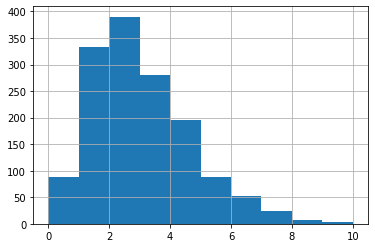

In [36]:
#look at the number of segments from each sample
df_seg1['n_segments']=df_seg1.cough_segments.apply(lambda x :len(x))

#histogram of numebr of coughs
df_seg1.n_segments.hist()
plt.show()

In [103]:
#explode segments into rows

df_seg1=df_seg1.explode('cough_segments')

In [104]:
df_seg1.shape

(3847, 8)

In [105]:
#check for missing segments
df_seg1.isnull().sum()

uuid               0
cough_detected     0
status             0
x                  0
fs                 0
target_binary      0
cough_segments    89
cough_mask         0
dtype: int64

In [168]:
#drop missing segments
df_seg1.dropna(inplace=True)

#reset index
df_seg1=df_seg1.reset_index()

In [49]:
def plot_cough(i,df=df_sub):
    '''
    function to plot cough
    i: index of dataframe
    df: dataframe
    '''

    plt.plot(df['x'].iloc[i])
    plt.plot(df['cough_mask'].iloc[i])

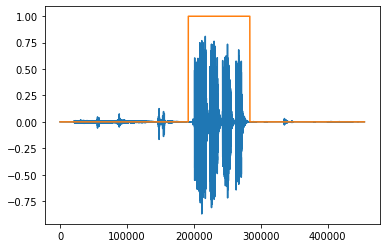

In [53]:
#view cough signal
plot_cough(45,df_sub)

In [80]:
def plot_multi_cough(i,df,mask='cough_mask',column='x'):
    
    '''
    function to plot multiple_coughs'''
    
    fig,ax=plt.subplots(ncols=2,nrows=4,figsize=(16,20))
    
    a=0
    b=0
    
    for z,x in enumerate(i):
        
        ax[b,a].plot(df[column][x])
        ax[b,a].plot(df[mask][x])
        ax[b,a].set_title(x)
        
        b=math.floor((z+1)/2)
        a=(z+1)-(b*2)

Second segmentation

I will repeat the steps I did for the previous segmentaion but with different paramenters in the segmentation_fucntion to create more segments


Adjusted paramters

cough_padding=0.25,
min_cough_len=0.15,
th_l_multiplier=0.2

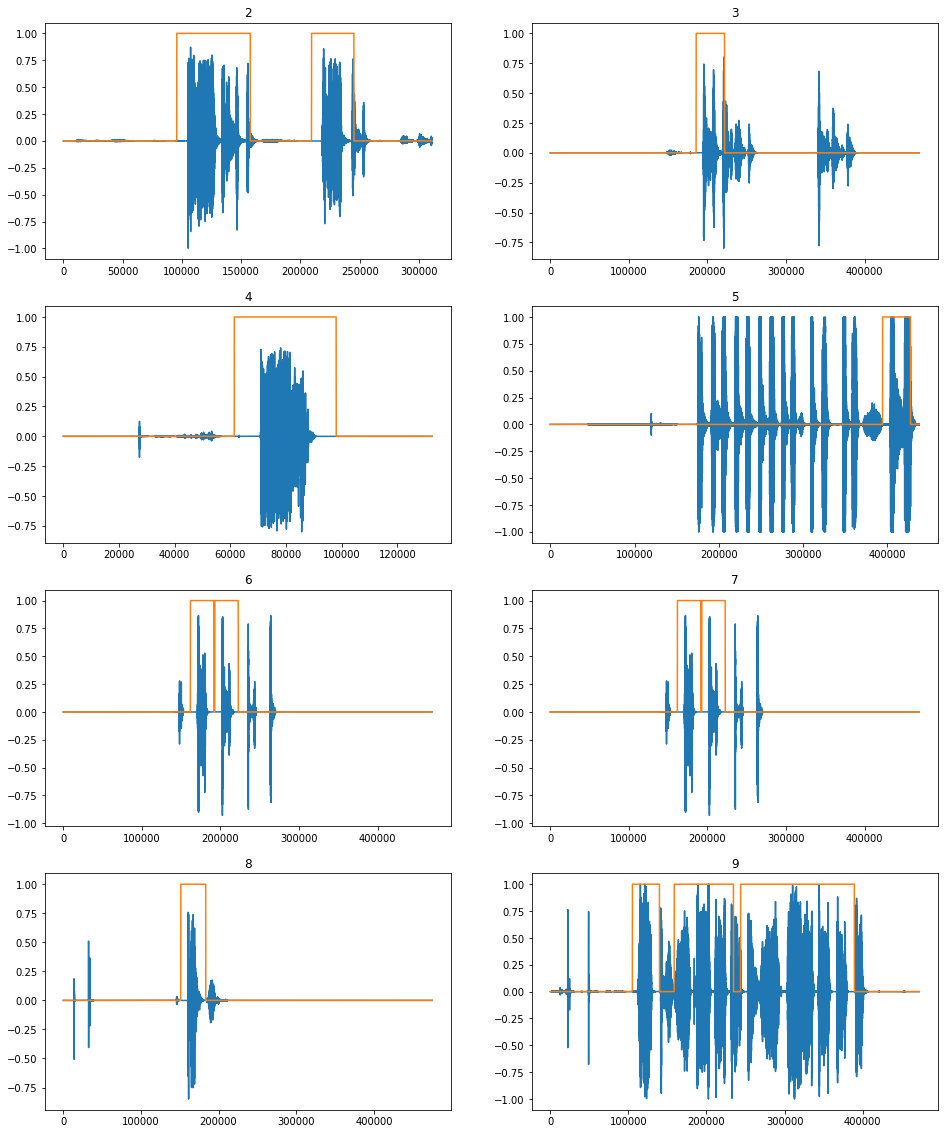

In [169]:
plot_multi_cough(range(2,10),df_seg1)

In [167]:
df_seg1

,uuid,cough_detected,status,x,fs,target_binary,cough_segments,cough_mask,mfcc_1,mfcc_2,...,mfcc_12,mfcc_13,Spectral_Centroid,Spectral_Rolloff,Spectral_Spread,Spectral_Skewness,Spectral_Kurtosis,Spectral_Bandwidth,zcr,rms
0,005b8518-03ba-4bf5-86d2-005541442357,1.0,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,0,"[-0.00039672852, -0.00021362305, 3.0517578e-05...","[False, False, False, False, False, False, Fal...",-260.521301,185.380936,...,9.265068,8.986805,2072.216901,5516.0,2310.474723,2.598188,16.349013,1.197786e+06,0.046415,0.203666
0,005b8518-03ba-4bf5-86d2-005541442357,1.0,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,0,"[-0.14230347, -0.15118408, -0.15563965, -0.154...","[False, False, False, False, False, False, Fal...",-277.917236,186.542465,...,12.070834,15.452579,1808.891471,4193.0,2262.234030,3.726104,25.571572,7.779901e+05,0.042796,0.147088
0,005b8518-03ba-4bf5-86d2-005541442357,1.0,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,0,"[3.0517578e-05, 3.0517578e-05, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...",-322.409607,149.458847,...,5.801750,13.509492,1843.011838,4729.0,2142.957943,2.241565,12.727606,8.209938e+05,0.026908,0.163412
1,008ba489-31ad-44d8-856b-fcf72369dc46,1.0,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...",-349.903198,123.723427,...,-8.311488,1.056981,2736.536995,5085.0,2436.949433,1.722600,10.684122,8.890700e+05,0.047470,0.107121
2,00bf9f83-2e8f-47cf-a4f2-97f2beceebc1,1.0,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...",-358.453949,119.486870,...,-5.697177,3.001040,1628.608567,4359.0,1841.481078,1.370664,4.149917,7.611399e+05,0.015738,0.201068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,ffe0658f-bade-4654-ad79-40a468aabb03,1.0,COVID-19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,1,"[3.0517578e-05, 3.0517578e-05, 3.0517578e-05, ...","[False, False, False, False, False, False, Fal...",-209.944611,197.461685,...,-7.110559,1.086908,2231.852475,4521.0,2021.003549,2.570543,19.061638,1.498205e+06,0.037513,0.400287
1463,ffe0658f-bade-4654-ad79-40a468aabb03,1.0,COVID-19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,1,"[-0.6922302, -0.63830566, -0.5959778, -0.58474...","[False, False, False, False, False, False, Fal...",-224.117889,208.883514,...,-12.861559,-3.262640,2160.811241,4292.0,2304.020988,3.497424,24.584264,1.486953e+06,0.036715,0.345936
1463,ffe0658f-bade-4654-ad79-40a468aabb03,1.0,COVID-19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,1,"[0.053619385, 0.055664062, 0.057434082, 0.0589...","[False, False, False, False, False, False, Fal...",-206.394379,193.678635,...,-4.494109,2.620703,2356.649579,6039.0,2009.343403,1.234876,6.692094,1.643690e+06,0.044520,0.351177
1464,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,1.0,healthy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,0,"[0.016906738, 0.012817383, 0.007965088, 0.0046...","[False, False, False, False, False, False, Fal...",-265.679565,168.599091,...,-11.029887,-6.346490,1984.708079,4904.0,2871.843857,3.892277,22.675414,1.313193e+06,0.043304,0.231081


In [173]:
def play_cough(i,df):
    
    path='/Users/christian/Desktop/GA/dataset_labled.nosync/'
    file_name=df.uuid[i]
    
    return IPython.display.Audio(path+file_name+'.wav')

In [177]:
play_cough(8,df_seg1)

By plotting multiple coughs along with their segmentation mask, I could inspect how much of the audio signal was being lost. And by listening to the corresponding cough I could then find out of this lost audio was a cough or just background noise. In a lot of cases it was potentially useful information being discarded due to the fact they were too queit or too short in length. To rectify this I decided to segment the data again with different parameters to catch more information. 

### Segmentation 2 - Fine Segmentation

Second segmentation - I will repeat the steps I did for the previous segmentaion but with different paramenters in the segmentation_fucntion.


Adjusted paramters

cough_padding=0.25,
min_cough_len=0.15,
th_l_multiplier=0.2

In [78]:
#Fine segmentation
df_seg2['seg']=df_seg2.x.apply(segment_cough, args=(48000,0.25,0.15,0.2,2))

In [93]:
#the segment_cough function outputs a tuple so I will unpack it into seperate columns
features_to_cols('seg',['cough_segments','cough_mask'],df_seg2)

In [ ]:
#look at the number of segments from each sample
df_seg2['n_segments']=df_seg2.cough_segments.apply(lambda x :len(x))

#histogram of numebr of coughs
df_seg2.n_segments.hist()
plt.show()

In [108]:
#explode segments into rows

df_seg2=df_seg2.explode('cough_segments')

df_seg2.shape

(4298, 9)

In [120]:
#check for missing segments
df_seg2.isnull().sum()

uuid               0
cough_detected     0
status             0
x                  0
fs                 0
target_binary      0
cough_segments    75
cough_mask         0
n_segments         0
dtype: int64

In [170]:
#drop missing segments
df_seg2.dropna(inplace=True)

#reset index
df_seg2=df_seg2.reset_index()

In [171]:
df_seg2.shape

(4223, 31)

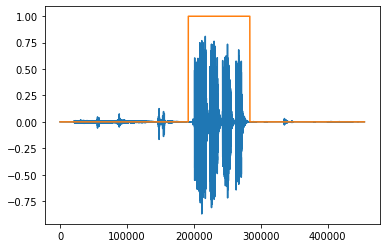

In [53]:
#view cough signal
plot_cough(45,df_sub)

## Feature Extraction

In this next section I will extract my predictor features from the cough segments.

I will be looking at:

Mel-Frequency Cepstrum Coefficients (MFCCs) -
The mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. MFCCs are coefficients that collectively make up an MFC


Spectral Centroid -
This is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound.

Spectral Rolloff -
The frequency below which a specified percentage (95%) of the total spectral energy lies

Spectral Spread -
This describes the average deviation of the rate-map around its centroid, which is commonly associated with the bandwidth of the signal. Noise-like signals have usually a large spectral spread, while individual tonal sounds with isolated peaks will result in a low spectral spread

Spectral Skewness -
Returns the spectral skewness of the signal, x, over time

Spectral Kurtosis -
A statistical quantity that contains low values where data is stationary and Gaussian, and high values where transients occur.


Zero Cross Rate (ZCR) -
Is the rate at which a signal changes its sign from positive to negative or vice versa within a given time frame

Root Mean Sqaure Power (RMS)



### MFCC

In [54]:
def MFCC(cough,n,fs=48000):
    
    '''
    function extract MFCCs
    cough: cough segment
    n: number of mfccs
    fs: sample rate '''
    
    mfccs=librosa.feature.mfcc(cough,sr=fs,n_mfcc=n)
        
    mfccs_processed = np.mean(mfccs.T,axis=0)
    
    return mfccs_processed

In [57]:
#apply mfcc function

#choose to initally extract 13 coefficients as this is commonly used number in practice 
df_sub['mfcc']=df_sub.cough_segments.apply(MFCC,args=(13,48000))

In [58]:
#need to unpack coeffeicints from array to individual columns

#names of new columns
mfcc_13=['mfcc_'+str(x) for x in range(1,14)]

#using previous function to unpack to new columns
features_to_cols('mfcc',mfcc_13,df_sub)

df_sub.columns

Index(['uuid', 'cough_detected', 'status', 'x', 'fs', 'cough_segments',
       'cough_mask', 'n_segments', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
       'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13'],
      dtype='object')

### Spectral Features

In [59]:
#function to extract spectral features

def spectral_features(x,fs=48000):
    names = ["Spectral_Centroid","Spectral_Rolloff","Spectral_Spread","Spectral_Skewness","Spectral_Kurtosis","Spectral_Bandwidth"]
    #fs, x = data
    magnitudes = np.abs(np.fft.rfft(x)) # magnitudes of positive frequencies
    length = len(x)
    freqs = np.abs(np.fft.fftfreq(length, 1.0/fs)[:length//2+1]) # positive frequencies
    sum_mag = np.sum(magnitudes)

    # spectral centroid = weighted mean of frequencies wrt FFT value at each frequency
    spec_centroid = np.sum(magnitudes*freqs) / sum_mag

    #spectral roloff = frequency below which 95% of signal energy lies
    cumsum_mag = np.cumsum(magnitudes)
    spec_rolloff = np.min(np.where(cumsum_mag >= 0.95*sum_mag)[0]) 

    #spectral spread = weighted standard deviation of frequencies wrt FFT value
    spec_spread = np.sqrt(np.sum(((freqs-spec_centroid)**2)*magnitudes) / sum_mag)

    #spectral skewness = distribution of the spectrum around its mean
    spec_skewness = np.sum(((freqs-spec_centroid)**3)*magnitudes) / ((spec_spread**3)*sum_mag)

    #spectral kurtosis = flatness of spectrum around its mean
    spec_kurtosis =  np.sum(((freqs-spec_centroid)**4)*magnitudes) / ((spec_spread**4)*sum_mag)

    #spectral bandwidth = weighted spectral standard deviation
    p=2
    spec_bandwidth = (np.sum(magnitudes*(freqs-spec_centroid)**p))**(1/p)

    return np.array([spec_centroid, spec_rolloff, spec_spread, spec_skewness, spec_kurtosis, spec_bandwidth])

#list of the spectral feature names
spec_names = ["Spectral_Centroid","Spectral_Rolloff","Spectral_Spread","Spectral_Skewness","Spectral_Kurtosis","Spectral_Bandwidth"]

### Zero Cross Rate

In [84]:
# fucntion to extract the ZCR
def ZCR(cough, fs=48000):
    # data: wav file of segment; fs, signal = wavfile.read(file)
    # output: value of the feature
    ZCR = (np.sum(np.multiply(cough[0:-1], cough[1:]) < 0)/(len(cough)-1))
    return ZCR

### RMS Power

In [85]:
# function to extract RMS Power
def RMSP(cough, fs=48000):
    # data: wav file of segment; fs, signal = wavfile.read(file)
    # output: value of the feature
    RMS = np.sqrt(np.mean(np.square(cough)))
    return RMS

In [ ]:
#Extract all features for all segmenation dataframes

In [81]:
def extract_features(df, audio_col, n_mfcc):
    
    '''
    Function to extract all audio features to dataframe
    df:dataframe
    audio_col: column containing cough sample/segment
    n_mfcc: number of MFCCs to extract
    '''
    
    #MFCC
    mfcc_names=['mfcc_'+str(x) for x in range(1,n_mfcc+1)]
    df['mfcc']=df[audio_col].apply(MFCC,args=(n_mfcc,48000))
    features_to_cols('mfcc',mfcc_names,df)
    
    #Spectral Features
    df['spec_features']=df[audio_col].apply(spectral_features)
    features_to_cols('spec_features',spec_names,df)
    
    #ZCR
    df['zcr']=df[audio_col].apply(ZCR)
    
    #RMS
    df['rms']=df[audio_col].apply(RMSP)

In [ ]:
#extract features no for segementation
extract_features(df_seg0,'x',13)

In [90]:
df_seg0.columns

Index(['uuid', 'cough_detected', 'status', 'x', 'fs', 'target_binary',
       'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
       'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13',
       'Spectral_Centroid', 'Spectral_Rolloff', 'Spectral_Spread',
       'Spectral_Skewness', 'Spectral_Kurtosis', 'Spectral_Bandwidth', 'zcr',
       'rms'],
      dtype='object')

In [110]:
#extract features no for coarse segementation df
extract_features(df_seg1,'cough_segments',13)

In [149]:
#extract features no for fine segementation df
extract_features(df_seg2,'cough_segments',13)

In [ ]:
#histograms of all the features??
#heatmaps

## EDA

I will use heatmaps to examine the correlation between fetaures and with the target variable for each dataframe

In [ ]:
total_features=mfcc_13+spec_names+['zcr','rms']

(22, 0)

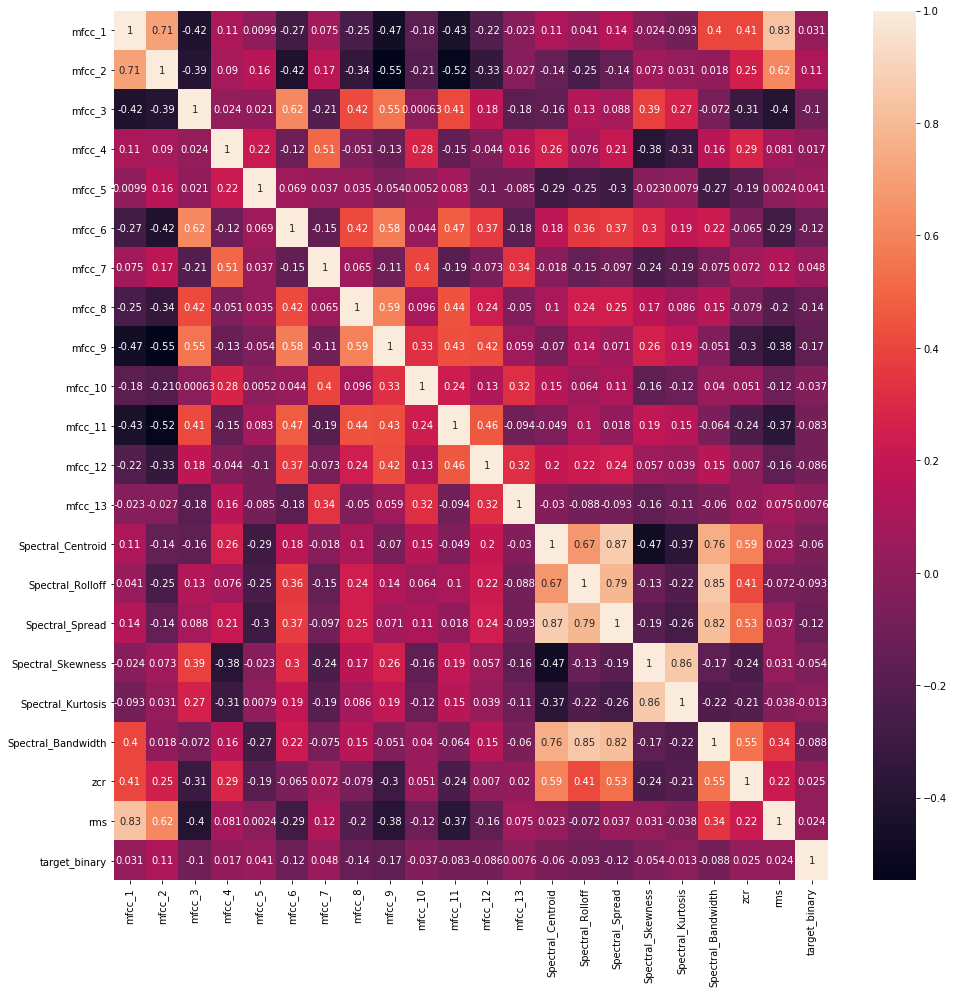

In [165]:
plt.figure(figsize=(16,16))
sns.heatmap(df_seg0[total_features+['target_binary']].corr(),annot=True)
plt.ylim([len(df_seg0[total_features+['target_binary']].columns),0])

(22, 0)

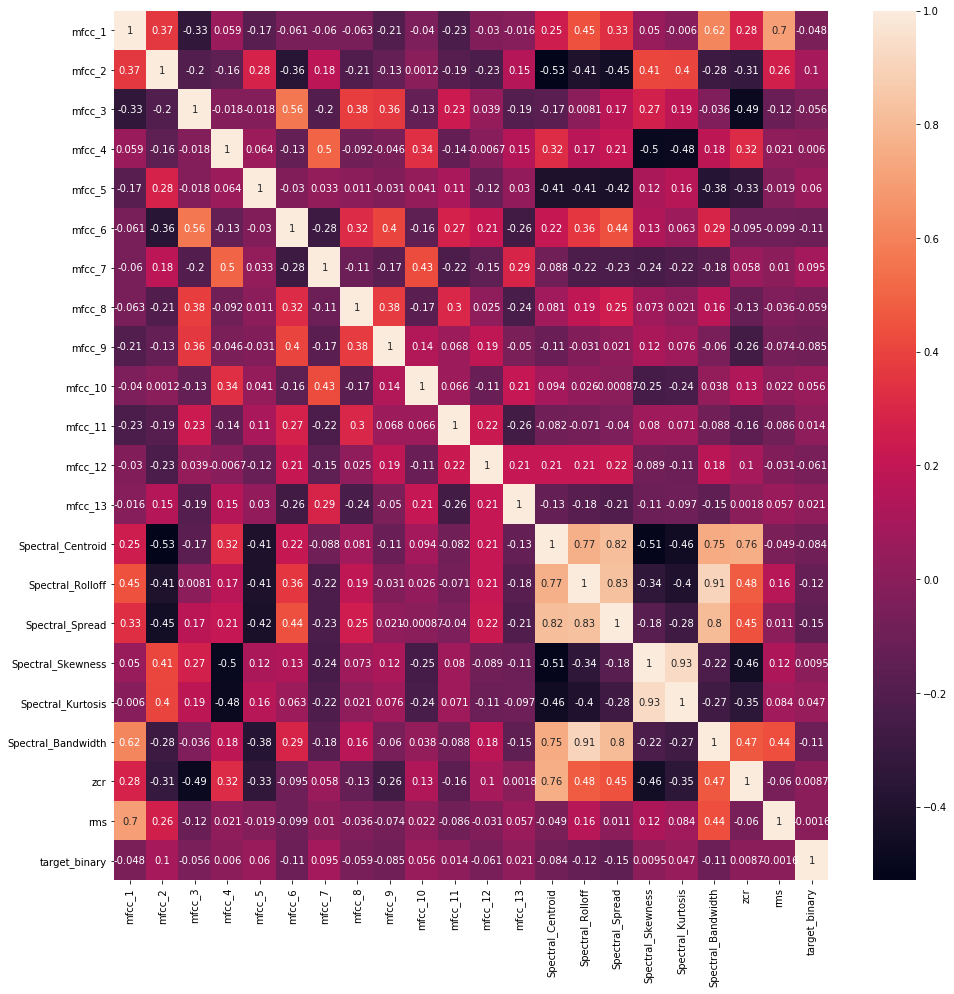

In [164]:
plt.figure(figsize=(16,16))
sns.heatmap(df_seg1[total_features+['target_binary']].corr(),annot=True)
plt.ylim([len(df_seg1[total_features+['target_binary']].columns),0])

(22, 0)

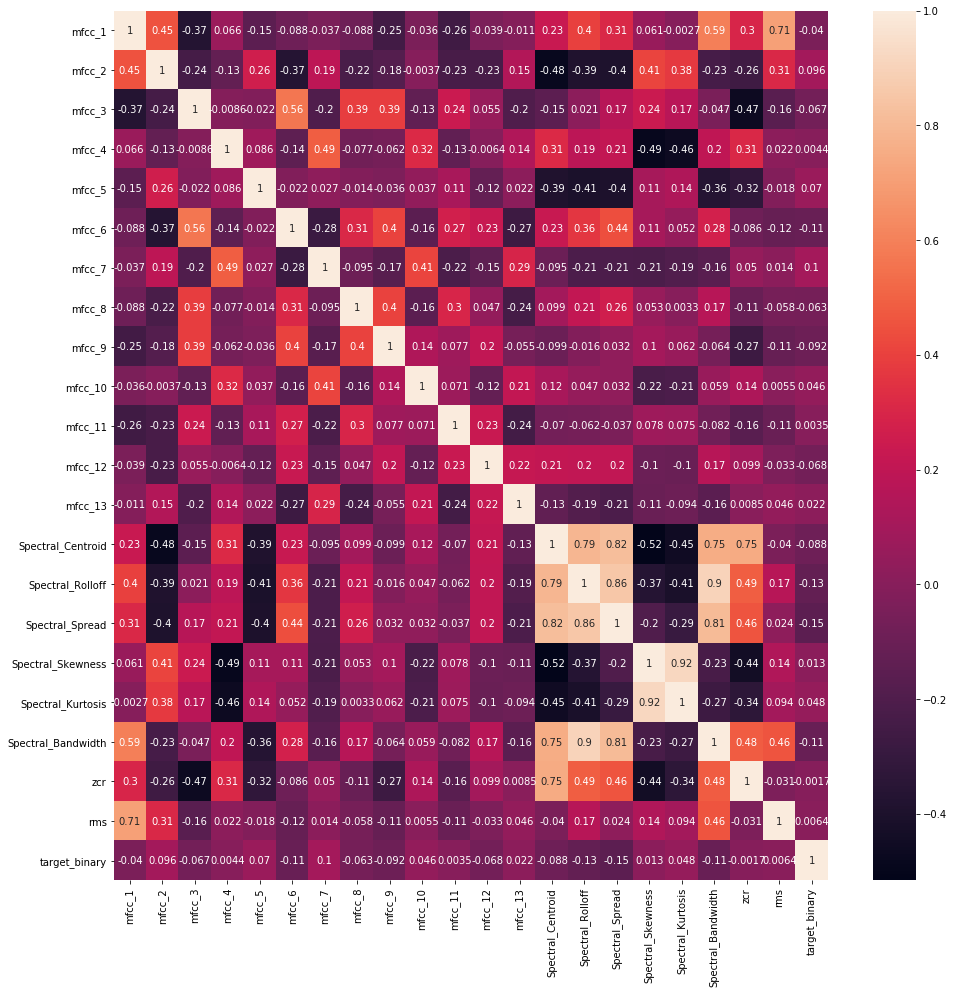

In [163]:
plt.figure(figsize=(16,16))
sns.heatmap(df_seg2[total_features+['target_binary']].corr(),annot=True)
plt.ylim([len(df_seg2[total_features+['target_binary']].columns),0])

In [116]:
#save dataframes as csvs

df_seg0.to_csv('df_seg0.csv',index=False)
df_seg1.to_csv('df_seg1.csv',index=False)
df_seg2.to_csv('df_seg2.csv',index=False)
df_seg2_40mfcc.to_csv('df_seg2_40mfcc.csv',index=False)

After some initial modelling, I wanted to explore if adding more MFCCs would imporve the performance of my models. Below I create a new dataframe with the fine segmentation and extract 40 MFCCs along with the other features.

In [129]:
#create database for fine segmentation + 40MFCC
df_seg2_40mfcc=df_seg2[['uuid', 'cough_detected', 'status', 'x', 'fs', 'target_binary',
       'cough_segments', 'cough_mask', 'n_segments']].copy()

In [131]:
#extract features no for fine segementation df
extract_features(df_seg2_40mfcc,'cough_segments',40)

In [ ]:
#save datafrane as csv
df_seg2_40mfcc.to_csv('df_seg2_40mfcc.csv',index=False)